### This notebook includes the basic joint GCS and PCS using Gumbel-softmax differentiable sampling technique. Initialization with a known constellation is required when bit metric decoding is used.

In [1]:
%reset

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense, LayerNormalization
from tensorflow.nn import relu
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
import sionna as sn
import matplotlib.pyplot as plt

In [19]:
symbol_points_qam64 = np.array([-1.08012344973464 + 1.08012344973464j
,-1.08012344973464 + 0.771516749810460j
,-1.08012344973464 + 0.154303349962092j
,-1.08012344973464 + 0.462910049886276j
,-0.771516749810460 + 1.08012344973464j
,-0.771516749810460 + 0.771516749810460j
,-0.771516749810460 + 0.154303349962092j
,-0.771516749810460 + 0.462910049886276j
,-0.154303349962092 + 1.08012344973464j
,-0.154303349962092 + 0.771516749810460j
,-0.154303349962092 + 0.154303349962092j
,-0.154303349962092 + 0.462910049886276j
,-0.462910049886276 + 1.08012344973464j
,-0.462910049886276 + 0.771516749810460j
,-0.462910049886276 + 0.154303349962092j
,-0.462910049886276 + 0.462910049886276j
,-1.08012344973464 - 1.08012344973464j
,-1.08012344973464 - 0.771516749810460j
,-1.08012344973464 - 0.154303349962092j
,-1.08012344973464 - 0.462910049886276j
,-0.771516749810460 - 1.08012344973464j
,-0.771516749810460 - 0.771516749810460j
,-0.771516749810460 - 0.154303349962092j
,-0.771516749810460 - 0.462910049886276j
,-0.154303349962092 - 1.08012344973464j
,-0.154303349962092 - 0.771516749810460j
,-0.154303349962092 - 0.154303349962092j
,-0.154303349962092 - 0.462910049886276j
,-0.462910049886276 - 1.08012344973464j
,-0.462910049886276 - 0.771516749810460j
,-0.462910049886276 - 0.154303349962092j
,-0.462910049886276 - 0.462910049886276j
,1.08012344973464 + 1.08012344973464j
,1.08012344973464 + 0.771516749810460j
,1.08012344973464 + 0.154303349962092j
,1.08012344973464 + 0.462910049886276j
,0.771516749810460 + 1.08012344973464j
,0.771516749810460 + 0.771516749810460j
,0.771516749810460 + 0.154303349962092j
,0.771516749810460 + 0.462910049886276j
,0.154303349962092 + 1.08012344973464j
,0.154303349962092 + 0.771516749810460j
,0.154303349962092 + 0.154303349962092j
,0.154303349962092 + 0.462910049886276j
,0.462910049886276 + 1.08012344973464j
,0.462910049886276 + 0.771516749810460j
,0.462910049886276 + 0.154303349962092j
,0.462910049886276 + 0.462910049886276j
,1.08012344973464 - 1.08012344973464j
,1.08012344973464 - 0.771516749810460j
,1.08012344973464 - 0.154303349962092j
,1.08012344973464 - 0.462910049886276j
,0.771516749810460 - 1.08012344973464j
,0.771516749810460 - 0.771516749810460j
,0.771516749810460 - 0.154303349962092j
,0.771516749810460 - 0.462910049886276j
,0.154303349962092 - 1.08012344973464j
,0.154303349962092 - 0.771516749810460j
,0.154303349962092 - 0.154303349962092j
,0.154303349962092 - 0.462910049886276j
,0.462910049886276 - 1.08012344973464j
,0.462910049886276 - 0.771516749810460j
,0.462910049886276 - 0.154303349962092j
,0.462910049886276 - 0.462910049886276j])

In [3]:
class SamplingMechanism(Layer):
    def __init__(self, N, tau, snr_db, batch_size, device):
        super(SamplingMechanism, self).__init__()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(N, activation=None)
        self.tau = tau
        self.snr_db = snr_db
        self.batch_size = batch_size
        self.device = device

    def call(self, inputs=None):
        # Create a tensor with the SNR value
        snr_tensor = tf.constant([[self.snr_db]], dtype=tf.float32)

        # Move tensor to the specified device if needed
        with tf.device(self.device):
            # Pass the SNR value through the first dense layer
            a = self.dense1(snr_tensor)

            # Pass through the second dense layer
            logits = self.dense2(a)

            # Compute softmax output
            softmax_out = tf.nn.softmax(logits, axis=-1)

            logits = tf.tile(logits, [self.batch_size, 1])

            # Compute Gumbel-Softmax with straight-through sampling
            gumbel_dist = -tf.math.log(-tf.math.log(tf.random.uniform(tf.shape(logits), 0, 1) + 1e-20) + 1e-20)
            gumbel_logits = logits + gumbel_dist
            gumbel_softmax = tf.nn.softmax(gumbel_logits / self.tau, axis=-1)

            max_value = tf.argmax(gumbel_softmax, axis=-1)

            # Step 2: Compare each value in gumbel_softmax with the max_value
            hard_sample = tf.one_hot(max_value, depth=gumbel_softmax.shape[-1], dtype=tf.float32)
            # print("hard_sample:", hard_sample)

            straight_through = gumbel_softmax + tf.stop_gradient(hard_sample - gumbel_softmax)


        return straight_through, softmax_out


In [4]:
class Modulator(Layer):

    def __init__(self, constellation, **kwargs):
        super(Modulator, self).__init__(**kwargs)

        # Define the real and imaginary parts of the constellation as trainable variables
        # self.constellation_real = tf.Variable(constellation.real, dtype=tf.float32, trainable=True)
        # self.constellation_imag = tf.Variable(constellation.imag, dtype=tf.float32, trainable=True)
        self.constellation_real_init = constellation.real
        self.constellation_imag_init = constellation.imag

    def build(self, input_shape):
        self.constellation_real = self.add_weight(
            name="constellation_real",
            shape=self.constellation_real_init.shape,
            initializer=tf.constant_initializer(self.constellation_real_init),
            trainable=True
        )
        self.constellation_imag = self.add_weight(
            name="constellation_imag",
            shape=self.constellation_imag_init.shape,
            initializer=tf.constant_initializer(self.constellation_imag_init),
            trainable=True
        )

    def call(self, s, probabilities):
        # Combine the real and imaginary parts into a complex-valued constellation
        constellation_combined = tf.complex(self.constellation_real, self.constellation_imag)

        # Expand the signal dimension to align for matrix multiplication
        s = tf.expand_dims(s, axis=-1)

        # Calculate the normalization constant
        normalization_constant = tf.sqrt(
            tf.reduce_sum(probabilities * tf.abs(constellation_combined) ** 2)
        )

        normalization_constant = tf.complex(normalization_constant,0.0)

        # Normalize the constellation
        norm_constellation = tf.expand_dims(constellation_combined, axis=0)  # Add batch dimension
        norm_constellation = norm_constellation / normalization_constant
        norm_constellation = tf.expand_dims(norm_constellation, axis=0)  # Expand further for batch processing

        # Compute the modulated signal
        x_real = tf.matmul(tf.math.real(norm_constellation), s)
        x_imag = tf.matmul(tf.math.imag(norm_constellation), s)
        x = tf.complex(x_real, x_imag)

        return tf.squeeze(x, axis=-1)

In [10]:
class Demodulator_bitwise(Layer):
    def __init__(self, bits_per_symbol, snr_db):
        super(Demodulator_bitwise, self).__init__()
        self.dense1 = Dense(128, activation='relu')  # First Dense Layer
        self.dense2 = Dense(128, activation='relu')  # Second Dense Layer
        self.dense3 = Dense(bits_per_symbol, activation='sigmoid')                      # Output Dense Layer
        self.snr_db = snr_db                        # SNR in dB

    def call(self, y):
        # Ensure complex-valued input is split into real and imaginary parts
        y_real = tf.math.real(y)
        y_imag = tf.math.imag(y)

        # Create and broadcast SNR tensor
        snr_tensor = tf.constant([[self.snr_db]], dtype=tf.float32)
        brd_snr_tensor = tf.broadcast_to(snr_tensor, [tf.shape(y_real)[0], 1])

        # Concatenate real, imaginary, and SNR tensors along the last dimension
        stack_input = tf.concat([y_real, y_imag, brd_snr_tensor], axis=1)

        ## print('brd_snr_tensor.shape: ',brd_snr_tensor)

        # Pass the stacked input through the dense layers
        x = self.dense1(stack_input)
        x = self.dense2(x)
        logits = self.dense3(x)

        return logits

In [11]:
class Demodulator(Layer):
    def __init__(self, N, snr_db):
        super(Demodulator, self).__init__()
        self.dense1 = Dense(128, activation='relu')  # First Dense Layer
        self.dense2 = Dense(128, activation='relu')  # Second Dense Layer
        self.dense3 = Dense(N)                      # Output Dense Layer
        self.snr_db = snr_db                        # SNR in dB
        # self.device = device                        # Device (e.g., "cpu", "gpu")

    def call(self, y):
        # Ensure complex-valued input is split into real and imaginary parts
        y_real = tf.math.real(y)
        y_imag = tf.math.imag(y)

        # Create and broadcast SNR tensor
        snr_tensor = tf.constant([[self.snr_db]], dtype=tf.float32)
        brd_snr_tensor = tf.broadcast_to(snr_tensor, [tf.shape(y_real)[0], 1])

        # Concatenate real, imaginary, and SNR tensors along the last dimension
        stack_input = tf.concat([y_real, y_imag, brd_snr_tensor], axis=1)

        # Pass the stacked input through the dense layers
        x = self.dense1(stack_input)
        x = self.dense2(x)
        logits = self.dense3(x)

        # Apply softmax to logits
        pred_probs = tf.nn.softmax(logits, axis=-1)

        return pred_probs

class EndToEndSystem(Model):
    def __init__(self, N, constellation, snr_db, batch_size, tau=1.0):
        super(EndToEndSystem, self).__init__()
        self.No = 1/(10**(snr_db/10))
        self.sampling = SamplingMechanism(N, tau, snr_db, batch_size, device)
        self.modulator = Modulator(constellation)
        self.channel = sn.phy.channel.AWGN()
        self.demodulator = Demodulator(N, snr_db)
        self.loss_fn = CategoricalCrossentropy(from_logits=False)

    def call(self, inputs=None):
        # Sampling mechanism generates symbol indices and shaping probabilities
        s, shaping_probs = self.sampling()

        # Modulate the symbols
        x_mod = self.modulator(s, shaping_probs)

        # Transmit through the channel
        y = self.channel(x_mod, self.No)

        # Demodulate the received signal
        pred_probs = self.demodulator(y)

        s_detached = tf.stop_gradient(s)

        loss_ordinary = self.loss_fn(s_detached,pred_probs)
        entropy_value = -tf.reduce_sum(shaping_probs * tf.math.log(shaping_probs))

        loss = loss_ordinary - entropy_value

        return loss, loss_ordinary, entropy_value, shaping_probs

In [12]:
class EndToEndSystem_bitwise(Model):
    def __init__(self, N, constellation, snr_db, batch_size, device, bits_per_symbol, tau=1.0):
        super(EndToEndSystem_bitwise, self).__init__()
        self.No = 1/(10**(snr_db/10))
        self.sampling = SamplingMechanism(N, tau, snr_db, batch_size, device)
        self.modulator = Modulator(constellation)
        self.channel = sn.phy.channel.AWGN()
        self.demodulator = Demodulator_bitwise(bits_per_symbol, snr_db)
        self.loss_fn = BinaryCrossentropy(from_logits=False)
        self.bits_per_symbol = bits_per_symbol

    def call(self, inputs=None):
        # Sampling mechanism generates symbol indices and shaping probabilities
        s, shaping_probs = self.sampling()

        indices = tf.argmax(s, axis=1, output_type=tf.int64)  # use int64 here!

        # Step 2: Convert to binary bits
        shifts = tf.range(self.bits_per_symbol - 1, -1, -1, dtype=tf.int64)  # also int64

        # Right shift and mask
        bit_repr = tf.bitwise.right_shift(
            tf.expand_dims(indices, -1), shifts
        ) & 1

        # Modulate the symbols
        x_mod = self.modulator(s, shaping_probs)

        # Transmit through the channel
        y = self.channel(x_mod, self.No)

        # Demodulate the received signal
        logits = self.demodulator(y)

        loss_ordinary = self.bits_per_symbol*self.loss_fn(bit_repr,logits)
        entropy_value = -tf.reduce_sum(shaping_probs * tf.math.log(shaping_probs))

        loss = loss_ordinary - entropy_value
        # loss = loss_ordinary

        return loss, loss_ordinary, entropy_value, shaping_probs

In [13]:
def normalize_constellation(points, probabilities):

    # Compute the power of the constellation
    power = np.sum(probabilities * np.abs(points)**2)
    # Normalize the constellation points
    normalized_points = points / np.sqrt(power)
    return normalized_points

def plot_constellation_wlabels(points, probabilities):

    points = np.asarray(points)
    probabilities = np.asarray(probabilities).flatten()

    # Scale marker sizes for visibility
    marker_sizes = 300 * probabilities / max(probabilities)

    plt.figure(figsize=(8, 8))
    plt.scatter(points.real, points.imag, s=marker_sizes, alpha=0.7, c='b', edgecolors='k')

    # Annotate with 6-bit binary labels
    for i, pt in enumerate(points):
        label = format(i, '06b')  # 6-bit binary string
        plt.text(pt.real + 0.05, pt.imag + 0.05, label, fontsize=9, ha='left', va='bottom', color='darkred')

    # Add grid and formatting
    plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')
    plt.grid(True, linestyle=':')
    plt.xlabel("In-phase")
    plt.ylabel("Quadrature")
    plt.title("Normalized Constellation with Probabilities and Bit Labels")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()
    plt.savefig('const.png')

In [20]:
N = 64  # Number of classes (symbols)
bits_per_symbol = int(np.log2(N))
# k = np.arange(N)
# gray_seq = k ^ (k >> 1)
# angles = 2 * np.pi * np.arange(N) / N
# constellation = np.zeros(N, dtype=np.complex128)
#
# # place symbols according to Gray sequence
# for i in range(N):
#     constellation[gray_seq[i]] = np.exp(1j * angles[i]) # A Gray PSK constellation is used

# Generate phase angles equally spaced between 0 and 2pi
# angles = np.linspace(0, 2 * np.pi, N, endpoint=False)

# Convert the angles to complex symbols on the unit circle
# constellation = np.exp(1j * angles)

constellation = symbol_points_qam64

snr_db = 15  # SNR in dB
No = 1/(10**(snr_db/10))
tau = 10

# Batch size
batch_size = 10000

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

@tf.function
def train_step(model, optimizer):
    with tf.GradientTape() as tape:
        loss, loss_ordinary, entropy_value, _ = model()
        # loss,loss_ordinary, entropy_value,_ = model(tf.convert_to_tensor([1])) # Use this for symbol only optimization

    grads = tape.gradient(loss, model.trainable_weights)
    grads, glob_norm = tf.clip_by_global_norm(grads, 0.1) # An important step for better training
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss, loss_ordinary, entropy_value

train = True # Change to train your own model
if train :
    # Number of iterations used for training
    NUM_TRAINING_ITERATIONS = 10000 # 1000 is good value for convergence

    # Instantiating the end-to-end model for training
    model = EndToEndSystem_bitwise(N, constellation, snr_db, batch_size, device, bits_per_symbol, tau)
    # model = EndToEndSystem(N, constellation, snr_db, batch_size, tau)  # Use this for symbol only optimization


    # Define the custom learning rate schedule
    initial_lr = 0.001
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[20000, 80000],
        values=[initial_lr, 0.001, 0.001]
    )

    # Adam optimizer with dynamic learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


    # Adam optimizer (SGD variant)
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    # optimizer.lr.assign(0.001)
    for i in range(NUM_TRAINING_ITERATIONS):
        loss, loss_ordinary, entropy_value = train_step(model, optimizer)

        if i % 50 == 0:
            print(
                "Iteration", i,
                "loss", loss.numpy() / np.log(2),
                "loss_ordinary", loss_ordinary.numpy() / np.log(2),
                "entropy_value", entropy_value.numpy() / np.log(2)
            )



Iteration 0 loss 1.7196242570306717 loss_ordinary 6.4737337955252565 entropy_value 4.754109538494585
Iteration 50 loss -1.0854499267943236 loss_ordinary 4.8969679593296815 entropy_value 5.982417886124005
Iteration 100 loss -1.9438050182915496 loss_ordinary 4.0437874818316155 entropy_value 5.987592500123165
Iteration 150 loss -2.507003140412722 loss_ordinary 3.4713532034285075 entropy_value 5.978356343841229
Iteration 200 loss -3.154356845149989 loss_ordinary 2.8013418163359707 entropy_value 5.955698661485959
Iteration 250 loss -3.595496128231412 loss_ordinary 2.3621755182252455 entropy_value 5.9576716464566575
Iteration 300 loss -3.746696395563959 loss_ordinary 2.216530978446171 entropy_value 5.963227374010129
Iteration 350 loss -3.8292150473091415 loss_ordinary 2.142614898897146 entropy_value 5.971829946206287
Iteration 400 loss -3.8911838360680284 loss_ordinary 2.0776190435004227 entropy_value 5.968803051551102
Iteration 450 loss -3.953217978234244 loss_ordinary 2.0085783281380567 en

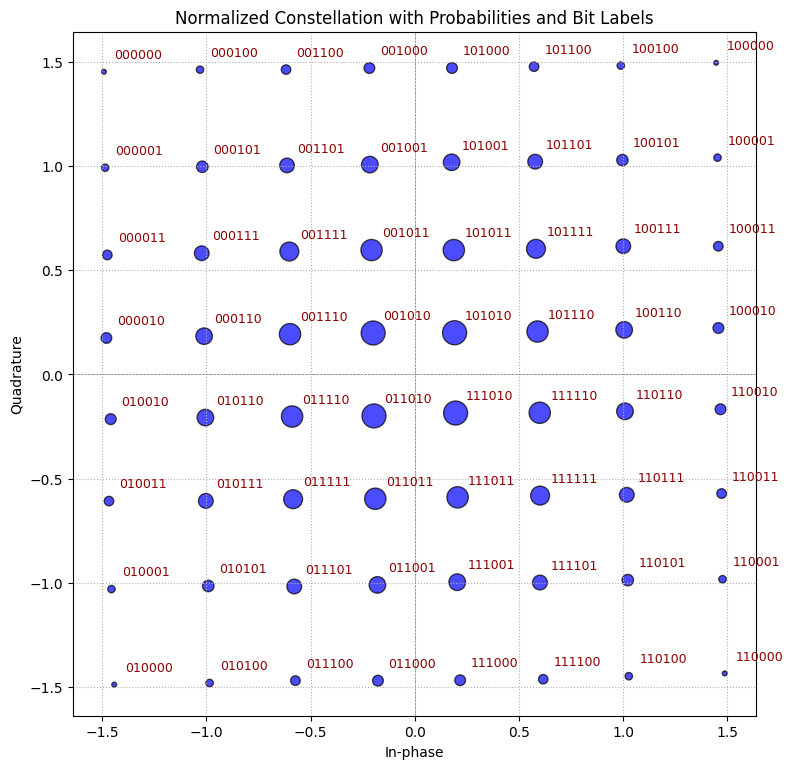

[[0.00163763 0.00384041 0.00807749 0.00652174 0.00382949 0.00939751
  0.01949099 0.01533401 0.00815823 0.01961429 0.04107816 0.03220754
  0.0063729  0.01534933 0.03238726 0.02555653 0.00167415 0.00384787
  0.00837157 0.00641328 0.00396037 0.0094381  0.01954358 0.01546387
  0.00828682 0.01957616 0.04111415 0.03239283 0.00658454 0.01541224
  0.03246253 0.02558088 0.00160949 0.00388271 0.00832112 0.00653074
  0.00389536 0.00919081 0.01974945 0.01536253 0.00826937 0.01950175
  0.04138355 0.0324688  0.00645612 0.01544536 0.0324378  0.02566392
  0.00168702 0.00400069 0.00830697 0.00658685 0.00391967 0.00938042
  0.01977071 0.01547629 0.00817551 0.0198886  0.04125153 0.03249506
  0.00639757 0.01562569 0.03228311 0.02560898]]


<Figure size 640x480 with 0 Axes>

In [21]:
with tf.GradientTape(persistent=False) as tape:
#     tape.watch(model.trainable_variables)  # Ensure variables are watched if needed, but no gradients will be calculated
    _,_,_,shaping_probs = model()


# Define constellation points (complex numbers)
points = model.modulator.constellation_real.numpy()+ 1j*model.modulator.constellation_imag.numpy()

# Define probabilities for each point
probabilities = shaping_probs.numpy()

# plt.savefig('const.pdf')

# Normalize the constellation
normalized_points = normalize_constellation(points, probabilities)

# Plot the constellation
plot_constellation_wlabels(normalized_points, probabilities)
print(probabilities)


In [54]:
for v in model.trainable_variables:
    print(v.path, v.shape)

end_to_end_system_bitwise_4/sampling_mechanism_16/dense_80/kernel (1, 128)
end_to_end_system_bitwise_4/sampling_mechanism_16/dense_80/bias (128,)
end_to_end_system_bitwise_4/sampling_mechanism_16/dense_81/kernel (128, 64)
end_to_end_system_bitwise_4/sampling_mechanism_16/dense_81/bias (64,)
end_to_end_system_bitwise_4/modulator_16/constellation_real (64,)
end_to_end_system_bitwise_4/modulator_16/constellation_imag (64,)
end_to_end_system_bitwise_4/demodulator_bitwise_4/dense_82/kernel (3, 128)
end_to_end_system_bitwise_4/demodulator_bitwise_4/dense_82/bias (128,)
end_to_end_system_bitwise_4/demodulator_bitwise_4/dense_83/kernel (128, 128)
end_to_end_system_bitwise_4/demodulator_bitwise_4/dense_83/bias (128,)
end_to_end_system_bitwise_4/demodulator_bitwise_4/dense_84/kernel (128, 6)
end_to_end_system_bitwise_4/demodulator_bitwise_4/dense_84/bias (6,)
